## Imports

In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt

## Ingest Data

In [8]:
# because the dataset is so big, this takes around 50 seconds on a Macbook Pro.

df = pd.read_csv("../data/raw_parking_data.csv")

In [9]:
# number of rows and columns

print(f"Data has {df.shape[0]} rows and {df.shape[1]} columns")

Data has 19234535 rows and 15 columns


In [10]:
# get addresses from previous

has_geom = df[~df.geom.isnull()]

In [11]:
has_location = has_geom.drop_duplicates(subset='Citation Location', keep="first")

In [19]:
df[df['Citation Location'] == '1318 FILBERT ST']['geom'].value_counts()

POINT (-122.42119800399996 37.800016984000024)    187
Name: geom, dtype: int64

## Basic EDA

In [12]:
# this takes a long time!

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

<AxesSubplot:>

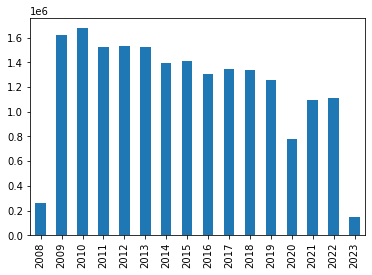

In [8]:
# number of tickets per year over time. the number of tickets has actually been going down

df['Citation Issued DateTime'].dt.year.value_counts().sort_index().plot(kind='bar')

In [4]:
df.head()

NameError: name 'df' is not defined

In [13]:
# filter dates (2022 and 2023 data only) using string matching first (more optimal than converting to datetime first)

# most_recent = df[df['Citation Issued DateTime'].str.contains('2022') | df['Citation Issued DateTime'].str.contains('2023')]
# most_recent.shape

most_recent = df[df['Citation Issued DateTime'] > pd.Timestamp(2022,1,1)]


In [14]:
# filter dates (2022 and 2023 data only) using string matching first (more optimal than converting to datetime first)

most_recent = df[df['Citation Issued DateTime'] > pd.Timestamp(2022,1,1)]
most_recent.shape

(1181689, 15)

In [22]:
# number of unique locations in most recent data

most_recent['Citation Location'].unique().shape

(359028,)

In [15]:
# drop columns that aren't filled for the most recent data

most_recent.drop(['Neighborhoods', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', 'geom'], axis=1, inplace=True)

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_1338/1014372275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_recent.drop(['Neighborhoods', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', 'geom'], axis=1, inplace=True)


In [19]:
# we lose about 50k / 1 mil records, but this seems ok for now.

got_geom = pd.merge(most_recent, has_location[['Citation Location', 'geom']], on='Citation Location')
got_geom.to_csv('../data/data_2022_with_geom.csv', index=False)

In [70]:
# filter for street cleaning only

street_cleaning = most_recent[most_recent['Violation Description'] == 'STR CLEAN']
street_cleaning.shape

(533212, 15)

In [71]:
# newest data does not include geometry information

most_recent['geom'].isnull().sum()

1181649

In [72]:
# filter out rows with no location information (very few)

street_cleaning = street_cleaning[~street_cleaning['Citation Location'].isnull()]
street_cleaning.shape

(533210, 15)

In [73]:
# filter out rows with no address number (very few)

street_cleaning = street_cleaning[street_cleaning['Citation Location'].apply(lambda address: any(char.isdigit() for char in address))]
street_cleaning.shape

(532935, 15)

In [74]:
street_cleaning['Citation Location'].value_counts()

1190 MISSION ST      154
540 JONES ST         114
111 TAYLOR ST        113
1018 MISSION ST      109
450 JONES ST         100
                    ... 
275 BRIGHT ST          1
885 VERMONT ST         1
41 TINGLEY STREET      1
1520 INGALLS ST        1
450 SPEAR ST           1
Name: Citation Location, Length: 248263, dtype: int64

In [92]:
pd.Series(['157 09TH ST']).str.replace(r'0\dTH', '\1', regex=True)

0    157  ST
dtype: object

In [63]:
# remove leading zeros from numbered street e.g. 09TH ST -> 9TH ST
# TODO: this regex does not work. 

street_cleaning['Citation Location'] = street_cleaning['Citation Location'].str.replace(r'0\dTH', r'\dTH', regex=True)

In [64]:
# convert to datetime

street_cleaning['Citation Issued DateTime'] = pd.to_datetime(street_cleaning['Citation Issued DateTime'])

In [67]:
# sort by most recent

street_cleaning.sort_values('Citation Issued DateTime', ascending=False, inplace=True)
street_cleaning.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
19179250,959318916,2023-01-26 13:18:00,TRC7.2.22,STR CLEAN,2031 SANTIAGO ST,AZ,CCV0129,87.0,02/01/2023 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN
19175399,959039970,2023-01-26 13:16:00,TRC7.2.22,STR CLEAN,4125 FULTON ST,CA,3W31424,87.0,02/01/2023 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN
19180844,959101334,2023-01-26 13:13:00,TRC7.2.22,STR CLEAN,2305 GREAT HWY,TX,SMM7137,87.0,02/01/2023 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN
19179457,959258403,2023-01-26 13:07:00,TRC7.2.22,STR CLEAN,6449 FULTON ST,TX,TXW7551,87.0,02/01/2023 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN
19179226,959101312,2023-01-26 13:07:00,TRC7.2.22,STR CLEAN,2099 GREAT HWY,CO,BYD046,87.0,02/01/2023 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# put into the format required by the US Census website:
# https://geocoding.geo.census.gov/geocoder/locations/addressbatch

pd.DataFrame({'street': street_cleaning['Citation Location'].unique(), 'city': 'SAN FRANCISCO', 'state': 'CA', 'zip': None}).head(n=10000).to_csv('sample_address.csv', header=False)

In [111]:
# load and merge geocoded results (only 10000 addresses max)

geo = pd.read_csv('../data/geocode_beta.csv', header=None)
geo = geo[geo[2] == 'Match']
geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
geo = geo[[1, 5]]
geo.columns = ['street', 'latlong']
geo

,street,latlong
0,3450 20TH ST,"-122.41804939299999,37.75870168800003"
1,103 FONT BOULEVARD,"-122.47322397799996,37.715063685000075"
2,500 30TH ST,"-122.43097611299999,37.741839725000034"
3,2442 DIAMOND STREET,"-122.43542069499995,37.73867619600003"
4,193 JERSEY ST,"-122.42936935399996,37.75076959000006"
...,...,...
9995,858 HAYES ST,"-122.43050105099996,37.77592995200007"
9996,658 19TH AVE,"-122.47794738299996,37.77552203400006"
9997,199 JOOST AVE,"-122.43956244699996,37.73236658900004"
9998,744 PORTOLA DR,"-122.45373363999994,37.74440515300006"


In [123]:
sample_df = pd.merge(street_cleaning, geo, left_on='Citation Location', right_on='street', how='inner')
sample_df.drop(['Neighborhoods', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', 'geom'], axis=1, inplace=True)
sample_df.rename({'latlong': 'geom'}, inplace=True, axis=1)
sample_df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,street,geom
0,950344345,04/21/2022 11:53:00 AM,TRC7.2.22,STR CLEAN,625 EUCLID AVE,CA,8NCF941,84.0,04/30/2022 12:00:00 AM,625 EUCLID AVE,"-122.45602271999996,37.78396235800005"
1,948660355,03/03/2022 11:55:00 AM,TRC7.2.22,STR CLEAN,625 EUCLID AVE,CA,8P13263,84.0,03/14/2022 12:00:00 AM,625 EUCLID AVE,"-122.45602271999996,37.78396235800005"
2,953722490,08/04/2022 11:57:00 AM,TRC7.2.22,STR CLEAN,625 EUCLID AVE,CA,66210H3,87.0,10/13/2022 12:00:00 AM,625 EUCLID AVE,"-122.45602271999996,37.78396235800005"
3,958167416,12/15/2022 11:54:00 AM,TRC7.2.22,STR CLEAN,625 EUCLID AVE,CA,7GLY429,87.0,01/20/2023 12:00:00 AM,625 EUCLID AVE,"-122.45602271999996,37.78396235800005"
4,959087522,01/19/2023 11:58:00 AM,TRC7.2.22,STR CLEAN,625 EUCLID AVE,CA,05345K3,87.0,01/26/2023 12:00:00 AM,625 EUCLID AVE,"-122.45602271999996,37.78396235800005"


In [125]:
sample_df.to_csv('../data/sample_2022.csv', index=False)